<a href="https://colab.research.google.com/github/saraex6/Transfer-Learning-and-fine-tuning---VGG16-ResNet-50-Inception-V3-/blob/main/VGG_No_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 64
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing


In [ ]:


train_data_dir = '/content/gdrive/MyDrive/Paper_run/local 70 Train - 15 Val - 15 Test/Train'
test_data_dir = '/content/gdrive/MyDrive/Paper_run/local 70 Train - 15 Val - 15 Test/Test'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


Found 1022 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE


# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-sgoh3oel
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-sgoh3oel
  Created wheel for livelossplot: filename=livelossplot-0.5.4-cp37-none-any.whl size=22538 sha256=54e7561bc953a7be3ae6c62ef85f43018739185536edf077168596bbe82d521e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7iwifemc/wheels/77/01/ea/cef3581d9c77ece0fd685cc3eb1cd92dc68d8117b361ac65dc
Successfully built livelossplot


In [ ]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.inputs.tf_keras import PlotLossesCallback

from livelossplot import PlotLossesKeras

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


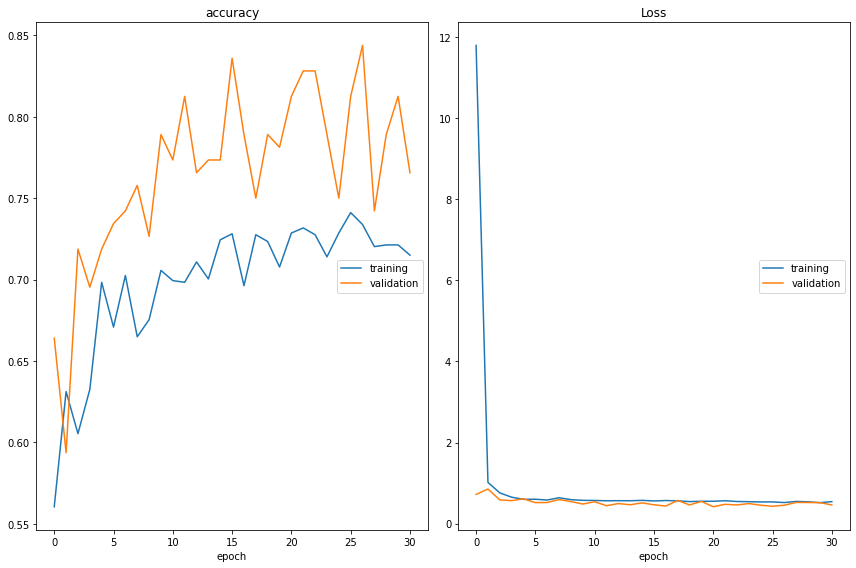

accuracy
	training         	 (min:    0.561, max:    0.741, cur:    0.715)
	validation       	 (min:    0.594, max:    0.844, cur:    0.766)
Loss
	training         	 (min:    0.517, max:   11.793, cur:    0.542)
	validation       	 (min:    0.417, max:    0.854, cur:    0.461)
CPU times: user 8h 21min 35s, sys: 3min 3s, total: 8h 24min 38s
Wall time: 4h 43min 14s


In [ ]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=50,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            #steps_per_epoch=2,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)


In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

vgg_f1 = f1_score(true_classes, vgg_pred_classes)
print("VGG16 Model f1_score without Fine-Tuning: {:.2f}%".format(vgg_f1 * 100))

vgg_average_precision_score = average_precision_score(true_classes, vgg_pred_classes)
print("VGG16 Model average_precision_score without Fine-Tuning: {:.2f}%".format(vgg_average_precision_score * 100))

vgg_precision_score = precision_score(true_classes, vgg_pred_classes)
print("VGG16 Model vgg_precision_score without Fine-Tuning: {:.2f}%".format(vgg_precision_score * 100))

vgg_recall_score = recall_score(true_classes, vgg_pred_classes)
print("VGG16 Model vgg_recall_score without Fine-Tuning: {:.2f}%".format(vgg_recall_score * 100))

vgg_log_loss = log_loss(true_classes, vgg_pred_classes)
print("VGG16 Model log_loss without Fine-Tuning: {:.2f}%".format(vgg_log_loss ))



VGG16 Model Accuracy without Fine-Tuning: 78.77%
VGG16 Model f1_score without Fine-Tuning: 79.64%
VGG16 Model average_precision_score without Fine-Tuning: 72.02%
VGG16 Model vgg_precision_score without Fine-Tuning: 76.52%
VGG16 Model vgg_recall_score without Fine-Tuning: 83.02%
VGG16 Model log_loss without Fine-Tuning: 7.33%


In [ ]:
#my_new_model.history.keys()
print(vgg_model.metrics_names)
print("VGG16 Model Average Val Accuracy without Fine-Tuning: {:.2f}%".format(np.mean(vgg_history.history['val_accuracy'])*100))
print("VGG16 Model Average Val Loss without Fine-Tuning: {:.2f}%".format(np.mean(vgg_history.history['val_loss'])))
print("VGG16 Model Average Training Accuracy without Fine-Tuning: {:.2f}%".format(np.mean(vgg_history.history['accuracy'])*100))
print("VGG16 Model Average Training Loss without Fine-Tuning: {:.2f}%".format(np.mean(vgg_history.history['loss'])))

['loss', 'accuracy']
VGG16 Model Average Val Accuracy without Fine-Tuning: 76.64%
VGG16 Model Average Val Loss without Fine-Tuning: 0.52%
VGG16 Model Average Training Accuracy without Fine-Tuning: 69.83%
VGG16 Model Average Training Loss without Fine-Tuning: 0.95%


In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
%%time
n_epochs = 50
plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  #steps_per_epoch=2, 
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)


In [ ]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))


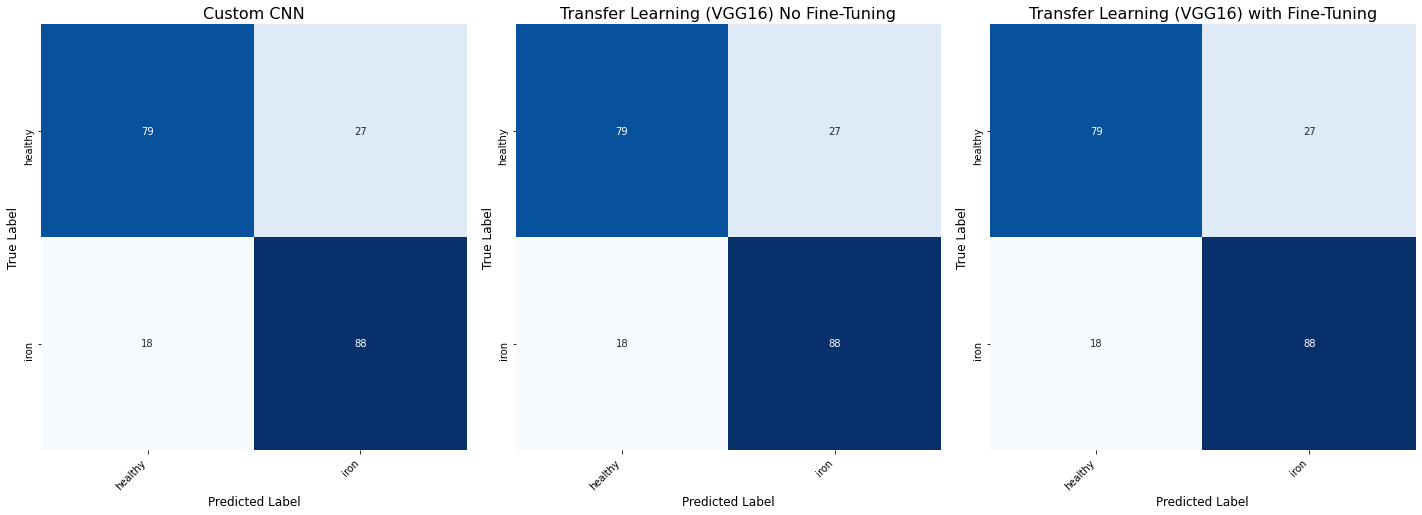

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Custom CNN") 

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()
